<a href="https://colab.research.google.com/github/maashha/Nonogram-solver/blob/main/Nonogram_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

In [2]:
pip install pycosat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycosat: filename=pycosat-0.6.6-cp310-cp310-linux_x86_64.whl size=169339 sha256=a3d92e403aef8799471e7dc57bf9ec3c37d5297be9983fdca26fe819edeb7b45
  Stored in directory: /root/.cache/pip/wheels/63/29/df/b8c22ca5812e2d7b342269a53add280b5bad42a540f34c3dc1
Successfully built pycosat


In [3]:
from Nonogram_project import NonogramSolver

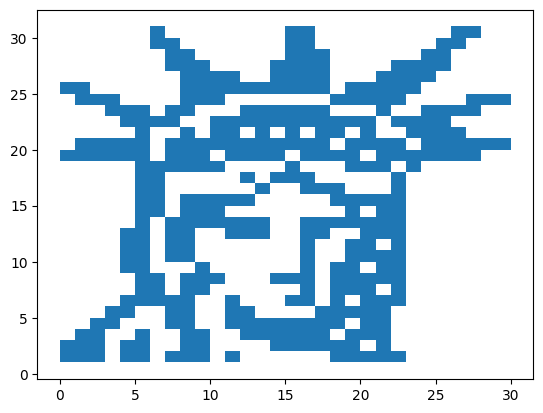

In [4]:
solver = NonogramSolver()
solver.load_from_file('tests/large_tests/large_test_1.txt')
solver.solve()
solver.draw()